In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as tick
import seaborn as sns

In [2]:
df_grants = pd.read_excel('./grants.xlsx', sheet_name = 'GR1-GR12', engine='openpyxl')

# fill nulls with appropriate values, 0 for $ and unknown for regions
df_grants = df_grants[df_grants.columns[~df_grants.columns.str.startswith('Unnamed')]]
df_grants['crowdfund_amount_contributions_usd'] = df_grants['crowdfund_amount_contributions_usd'].fillna(0.0) 
df_grants['total'] = df_grants['total'].fillna(0.0) 
df_grants['region'] = df_grants['region'].fillna('undefined')
df_grants['region'] = df_grants['region'].replace('none', 'undefined')
df_grants['crowdfund_amount_contributions_usd'] = df_grants['crowdfund_amount_contributions_usd'].fillna(0)
df_grants['match_amount'] = df_grants['match_amount'].fillna(0)
df_grants['total'] = df_grants['total'].fillna(0)

In [4]:
# source: https://dfrieds.com/data-visualizations/how-format-large-tick-values.html
def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

In [252]:
print("total funds raised: ${}".format(df_grants['total'].sum()))
print("total crowdfunds: ${}".format(df_grants['crowdfund_amount_contributions_usd'].sum()))
print("total matched amounts: ${}".format(df_grants['match_amount'].sum()))
print('total grants: {}'.format(df_grants['grant_id'].nunique()))

total funds raised: $16130338.612691468
total crowdfunds: $9357245.157712964
total matched amounts: $6773093.45493343
total grants: 2134


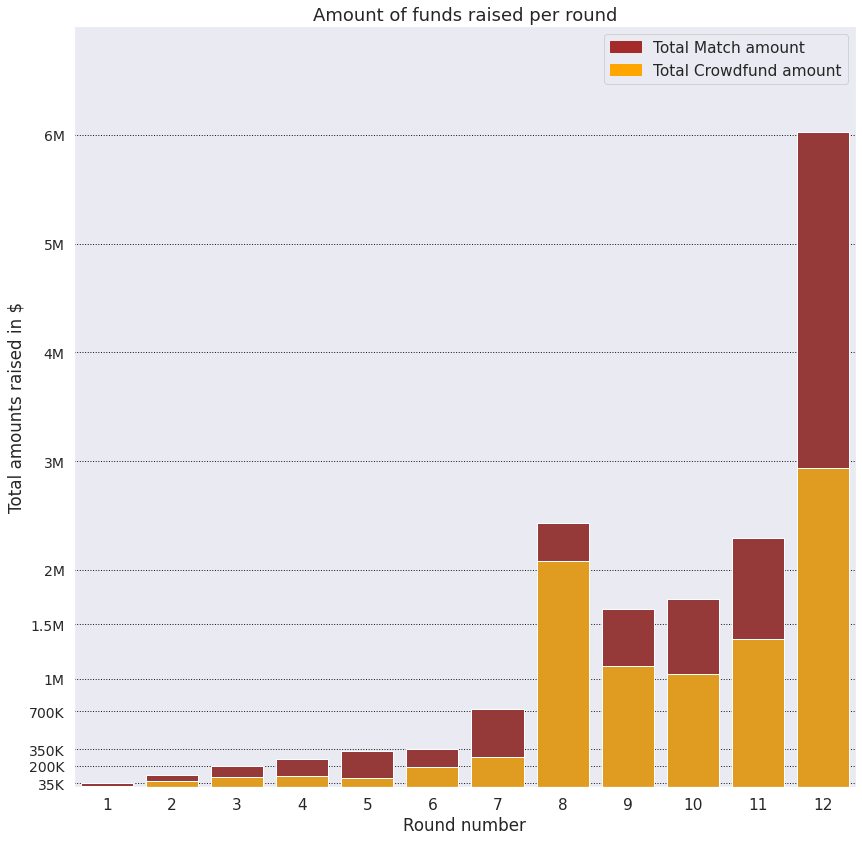

In [231]:
total = df_grants.groupby('round_number')['total'].sum().reset_index()
total_crowdfund_amount = df_grants.groupby('round_number')['crowdfund_amount_contributions_usd'].sum().reset_index()
total_crowdfund_amount.columns = ['round_number', 'total']

sns.set(font_scale=1.4)
plt.figure(figsize=(14, 14))
sns.set_style("darkgrid", {"grid.color": ".1", "grid.linestyle": ":"})

bar1 = sns.barplot(x="round_number",  y="total", data=total, color='brown')
bar2 = sns.barplot(x="round_number", y="total", data=total_crowdfund_amount, estimator=sum, ci=None,  color='orange')
top_bar = mpatches.Patch(color='brown', label='Total Match amount')
bottom_bar = mpatches.Patch(color='orange', label='Total Crowdfund amount')
plt.legend(handles=[top_bar, bottom_bar])
plt.xlabel("Round number")
plt.ylabel("Total amounts raised in $")
plt.ylim(0, 7000000)
plt.yticks([35000, 200000, 350000, 700000, 1000000, 1500000, 2000000, 3000000, 4000000, 5000000, 6000000], fontsize=14)
plt.ticklabel_format(style='plain', axis='y')
plt.title("Amount of funds raised per round", fontsize=18)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
plt.show()

Text(0.5, 1.0, 'Grants, new & old')

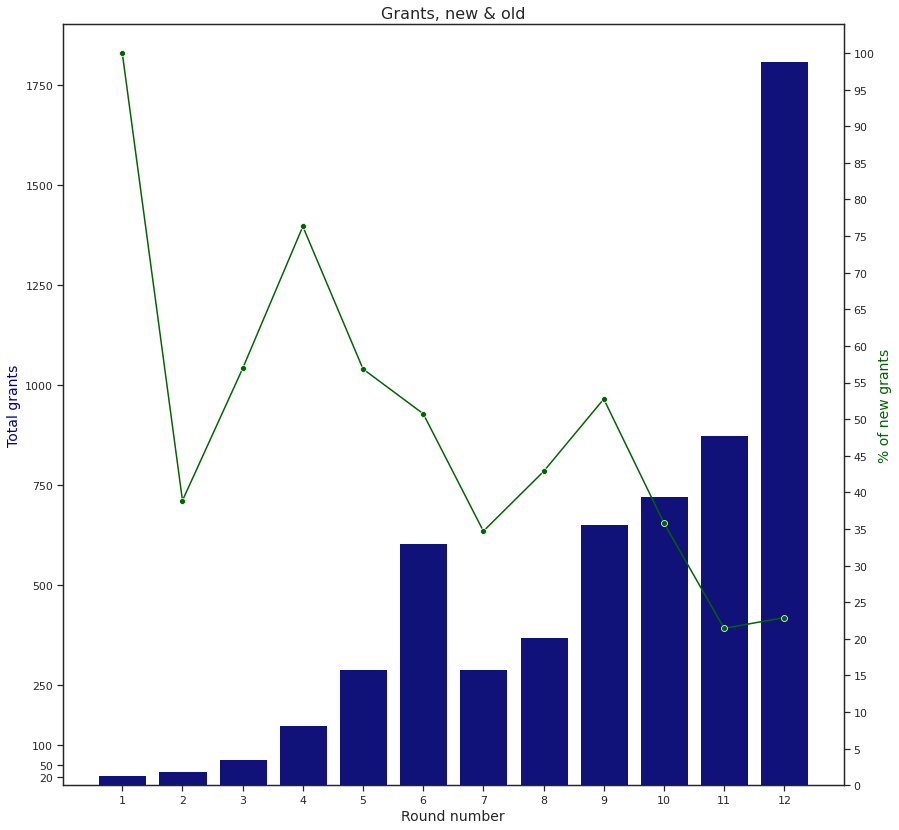

In [325]:
df_grants_per_round = df_grants.groupby('round_number')['grant_id'].size().reset_index(name='count')
df_grants_per_round.head(n=13)
df_new_grants = np.zeros((12, 1), dtype='int')
for r in range(1, 13):
    grants_this_round = df_grants.loc[df_grants['round_number'] == r, ['grant_id']]
    df_new_grants[r - 1] = grants_this_round['grant_id'].nunique()
    if r == 1:
        continue
    old_grant_pool = df_grants.loc[df_grants['round_number'] < r, ['grant_id']]
    old = 0
    for grant_id in grants_this_round['grant_id']:
        mask = grant_id == old_grant_pool['grant_id']
        if mask.values.sum() > 0:
            df_new_grants[r - 1] -= 1
df_grants_per_round['new_grants'] = df_new_grants
df_grants_per_round['pct_new'] = 100 * (df_grants_per_round['new_grants'] / df_grants_per_round['count'])
    
sns.set(rc = {'figure.figsize':(14,14)})
sns.set_style('ticks')

ax1 = sns.barplot(data=df_grants_per_round, x='round_number', y = 'count', color = 'darkblue')
ax2 = plt.twinx()
ax2 = sns.lineplot(x = df_grants_per_round.index, y = df_grants_per_round['pct_new'], marker = 'o', color = 'darkgreen', ax = ax2) 
ax1.set_xlabel('Round number', fontsize=14)
ax1.set_ylabel('Total grants', fontsize=14, color='darkblue')
ax1.set_yticks([20, 50, 100, 250, 500, 750, 1000, 1250, 1500, 1750])
ax2.set_ylabel('% of new grants', fontsize=14, color='darkgreen')
ax2.set_yticks(range(0, 101, 5))
plt.title('Grants, new & old', fontsize=16)


In [228]:
df_cont_region = df_grants[['round_number', 'crowdfund_amount_contributions_usd', 'region']]
df_cont_region.head()

,round_number,crowdfund_amount_contributions_usd,region
0,12,103838.934784,north_america
1,12,58715.043170,north_america
2,12,95279.643194,undefined
3,12,7815.294981,europe
4,12,25373.619603,europe


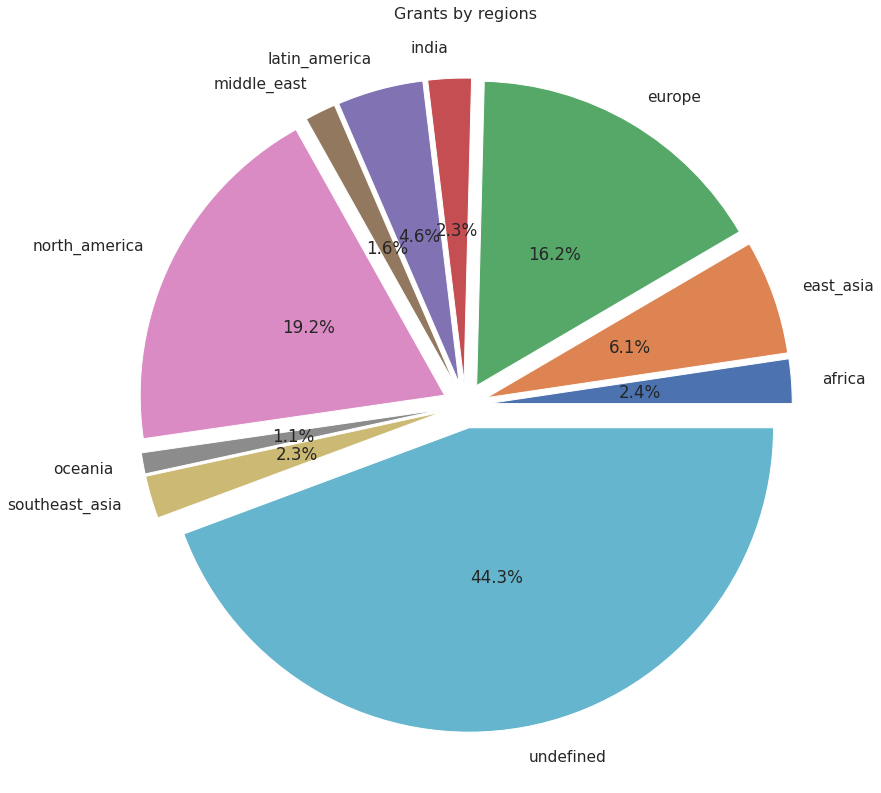

In [59]:
df_overall_regions = df_grants.groupby('region').size()
pie, ax = plt.subplots(figsize=[14,14])
regions_labels = df_overall_regions.keys()
plt.pie(x=df_overall_regions, autopct="%.1f%%", explode=[0.075] * len(regions_labels), labels=regions_labels, pctdistance=0.5)
plt.title("Grants by regions", fontsize=16);


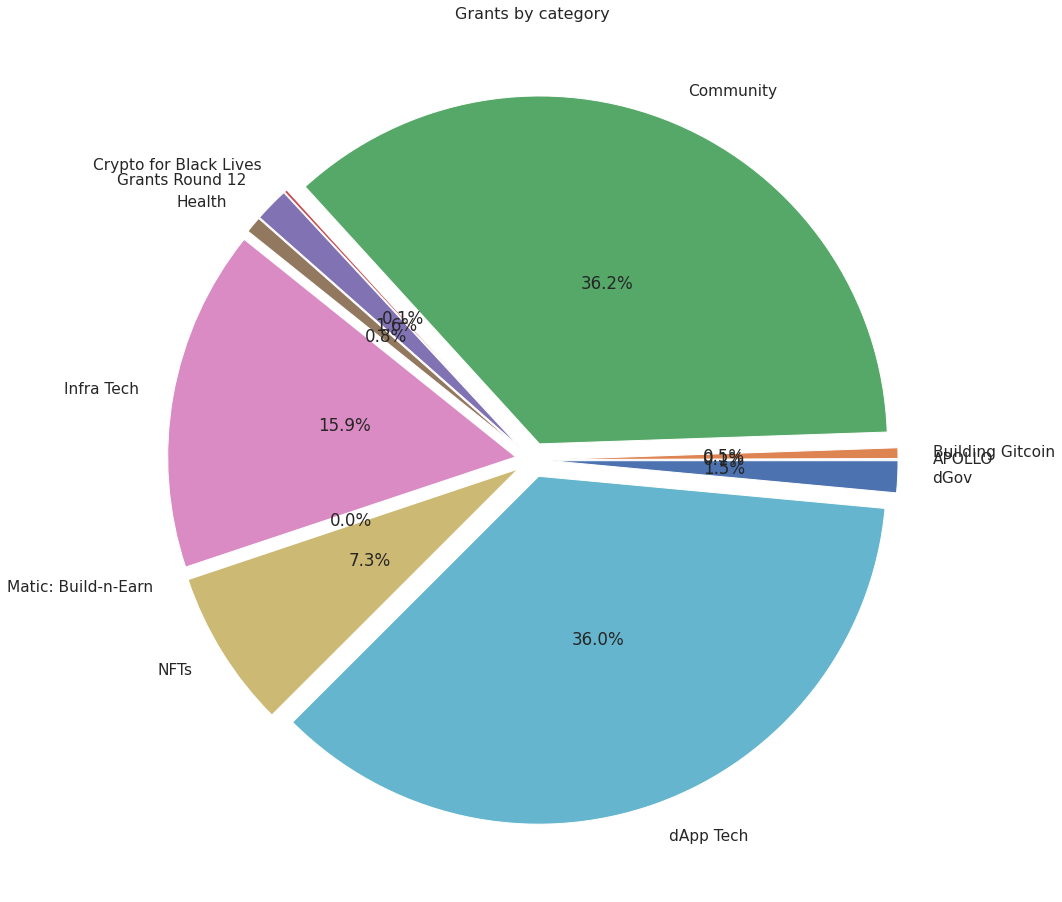

In [61]:
df_overall_categories= df_grants.groupby('category').size()
pie, ax = plt.subplots(figsize=[16,16])
category_labels = df_overall_categories.keys()
plt.pie(x=df_overall_categories, autopct="%.1f%%", explode=[0.05] * len(category_labels), labels=category_labels, pctdistance=0.5)
plt.title("Grants by category", fontsize=16);

In [5]:
def display_total_funds_raised(round_number, amount_min=0, amount_max=1e8,
                               yticks=[10000, 25000, 50000, 100000, 200000, 300000, 400000, 500000, 750000]):
    """
    plot (region and category)-wise total amount of funds raised
    """    
    df_fr = df_grants.loc[(df_grants['round_number'] == round_number)
                          & (df_grants['total'] >= amount_min)
                          & (df_grants['total'] <= amount_max),
                           ['round_number', 'total', 'category', 'region']]
    sns.set(font_scale=1.4)
    plt.figure(figsize=(14, 14))
    plt.title('(Region and category)-wise total amount of funds raised', fontsize=16)    
    sns.set_style('whitegrid', {'grid.color': '.1', 'grid.linestyle': ':'})
    ax = sns.stripplot(y='total', x='region', hue='category', data=df_fr)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    plt.xlabel('Regions')
    plt.ylabel("Total amount of funds raised in $")
    plt.yticks(yticks, fontsize=12)
    ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
    plt.show()

    
def display_crowdfunds_raised(round_number, amount_min=0, amount_max=1e8,
                               yticks=[10000, 25000, 50000, 100000, 200000, 300000, 400000, 500000, 750000]):
    """
    plot (region and category)-wise amount of crowdfunds raised
    """    
    df_fr = df_grants.loc[(df_grants['round_number'] == round_number)
                          & (df_grants['crowdfund_amount_contributions_usd'] >= amount_min)
                          & (df_grants['crowdfund_amount_contributions_usd'] <= amount_max),
                           ['round_number', 'crowdfund_amount_contributions_usd', 'category', 'region']]
    sns.set(font_scale=1.4)
    plt.figure(figsize=(14, 14))
    sns.set_style('whitegrid', {'grid.color': '.1', 'grid.linestyle': ':'})
    ax = sns.stripplot(y='crowdfund_amount_contributions_usd', x='region', hue='category', data=df_fr)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    plt.xlabel('Regions')
    plt.ylabel("Total amount of crowdfunds raised in $")
    plt.yticks(yticks, fontsize=12)
    ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
    plt.show()

def display_matched_funds_raised(round_number, amount_min=0, amount_max=1e8,
                               yticks=[10000, 25000, 50000, 100000, 200000, 300000, 400000, 500000, 750000]):
    """
    plot (region and category)-wise matched amount of funds raised
    """    
    df_fr = df_grants.loc[(df_grants['round_number'] == round_number)
                          & (df_grants['match_amount'] >= amount_min)
                          & (df_grants['match_amount'] <= amount_max),
                           ['round_number', 'match_amount', 'category', 'region']]
    sns.set(font_scale=1.4)
    plt.figure(figsize=(14, 14))
    sns.set_style('whitegrid', {'grid.color': '.1', 'grid.linestyle': ':'})
    ax = sns.stripplot(y='match_amount', x='region', hue='category', data=df_fr)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    plt.xlabel('Regions')
    plt.ylabel("Total amount of matched funds raised in $")
    plt.yticks(yticks, fontsize=12)
    ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
    plt.show()
    

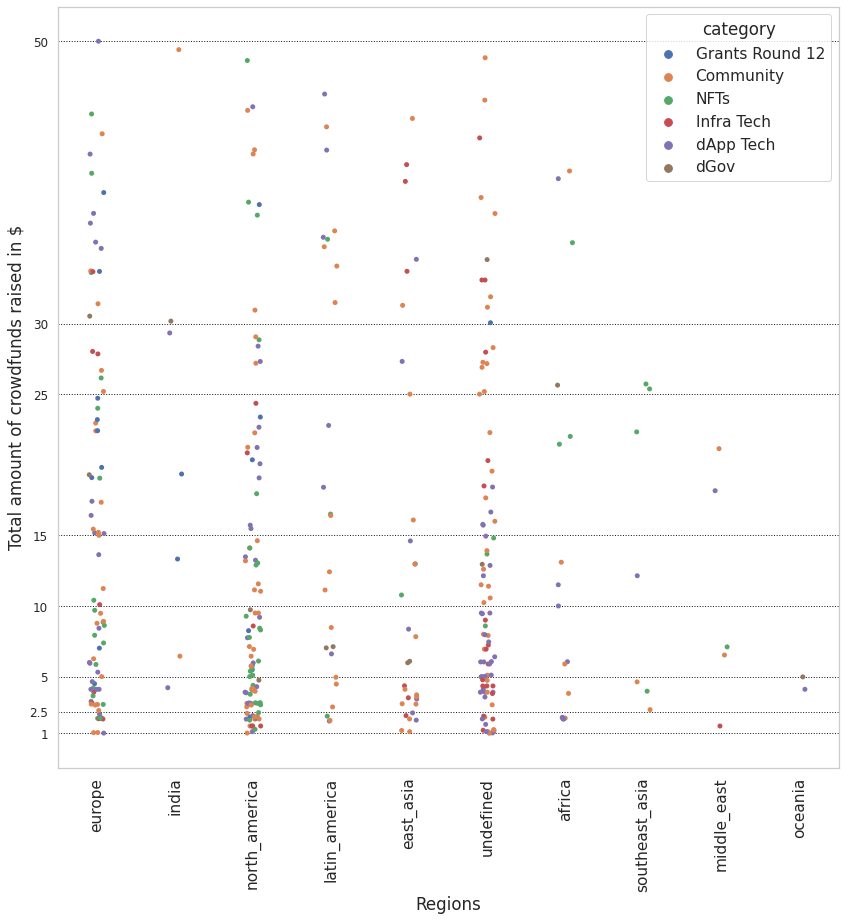

In [6]:
display_crowdfunds_raised(round_number = 12, amount_min = 1, amount_max = 50, yticks = [1, 2.5, 5, 10, 15, 25, 30, 50])

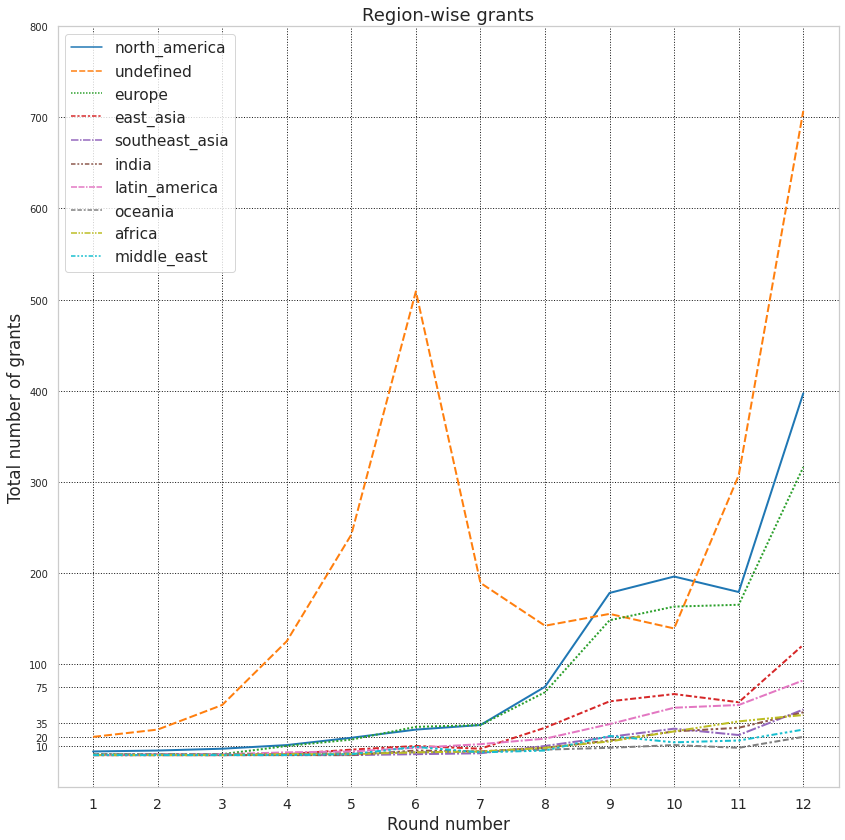

In [7]:
df_regions = pd.DataFrame(columns=df_grants['region'].unique())
for gr in df_grants['round_number'].unique()[::-1]:
    vc = df_grants[df_grants.round_number == gr]['region'].value_counts()
    df_regions = df_regions.append(vc, ignore_index=True)
df_regions = df_regions.fillna(0)
df_regions['round_number'] = range(1,13)
df_regions = df_regions.set_index('round_number')

sns.set(font_scale=1.4)
plt.figure(figsize=(14, 14))
sns.set_style("whitegrid", {"grid.color": ".1", "grid.linestyle": ":"})

sns.lineplot(data=df_regions, palette="tab10", linewidth=2)
plt.xticks(range(1,13), fontsize=14)
plt.xlabel("Round number")
plt.yticks([10, 20, 35, 75, 100, 200, 300, 400, 500, 600, 700, 800], fontsize=10)
plt.ylabel("Total number of grants")
plt.title("Region-wise grants", fontsize=18)
plt.show()

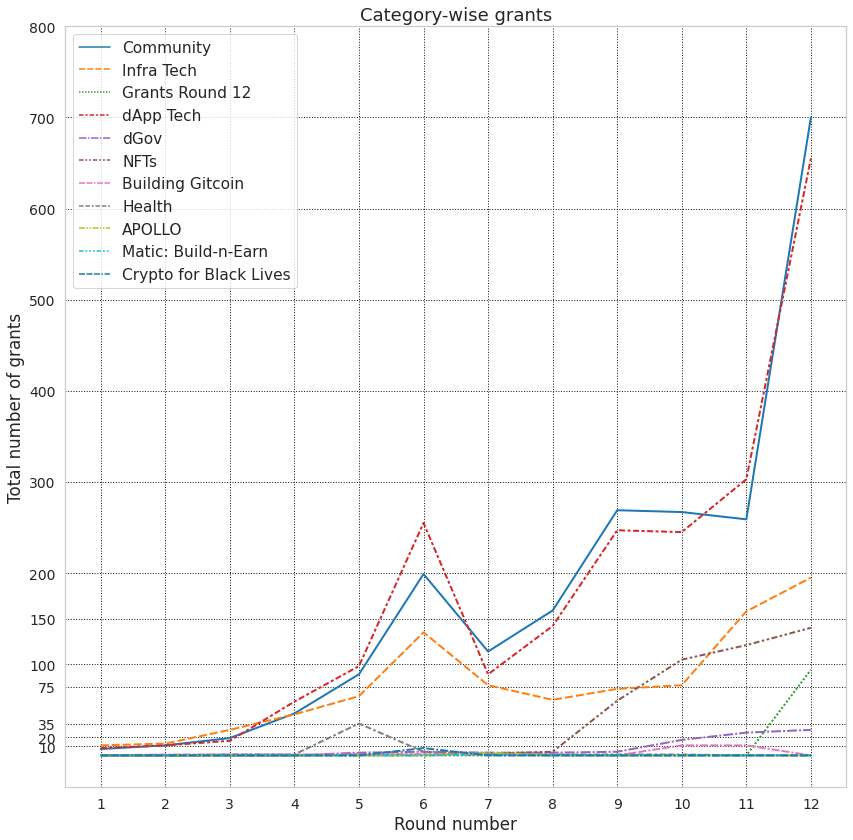

In [8]:
df_categories = pd.DataFrame(columns=df_grants['category'].unique())
for gr in df_grants['round_number'].unique()[::-1]:
    vc = df_grants[df_grants.round_number == gr]['category'].value_counts()
    df_categories = df_categories.append(vc, ignore_index=True)
df_categories = df_categories.fillna(0)
df_categories['round_number'] = range(1,13)
df_categories = df_categories.set_index('round_number')

sns.set(font_scale=1.4)
plt.figure(figsize=(14, 14))
sns.set_style("whitegrid", {"grid.color": ".1", "grid.linestyle": ":"})

sns.lineplot(data=df_categories, palette="tab10", linewidth=2)
plt.xticks(range(1,13), fontsize=14)
plt.xlabel("Round number")
plt.yticks([10, 20, 35, 75, 100, 150, 200, 300, 400, 500, 600, 700, 800], fontsize=14)
plt.ylabel("Total number of grants")
plt.title("Category-wise grants", fontsize=18)
plt.show()

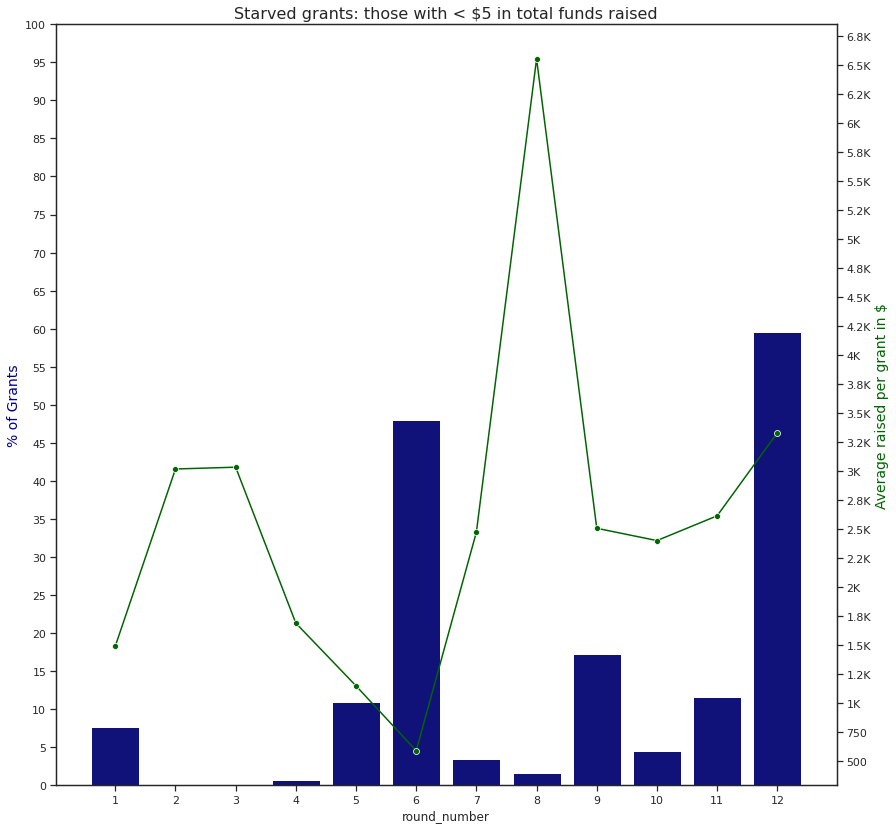

In [170]:
# trend of grants that have received almosst $0 in total amounts of funds

df_l5 = df_grants.loc[df_grants['total'] < 5, ['round_number', 'total']].groupby('round_number').size().to_frame(name='raised_lt_$5')
df_mean_total = df_grants[['round_number', 'total']].groupby('round_number')['total'].mean().reset_index(name='avg_raised')
df_starved = pd.merge(df_mean_total, df_l5, how='left', on='round_number').fillna(0)
df_grants_count = df_grants.groupby('round_number').size().reset_index(name='count')
df_starved['pct'] = 100 * (df_starved['raised_lt_$5'] / df_grants_count['count'])
df_starved.fillna(0, inplace=True)
df_grants.groupby('round_number').size().to_frame(name='count')['count']

sns.set(rc = {'figure.figsize':(14,14)})
sns.set_style('ticks')

ax1 = sns.barplot(data = df_starved, x = 'round_number', y = 'pct', color = 'darkblue') 
ax2 = plt.twinx()
ax2 = sns.lineplot(x=df_starved.index, y = df_starved['avg_raised'], marker = 'o', color = 'darkgreen', ax = ax2) 

plt.xlabel('Round number', fontsize=14)
ax1.set_ylabel('% of Grants', fontsize=14, color='darkblue')
ax1.set_yticks(range(0, 101, 5))
ax2.set_ylabel('Average raised per grant in $', fontsize=14, color='darkgreen')
ax2.set_yticks(range(500, 7000, 250))
ax2.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
plt.title('Starved grants: those with < $5 in total funds raised', fontsize=16)

plt.show()

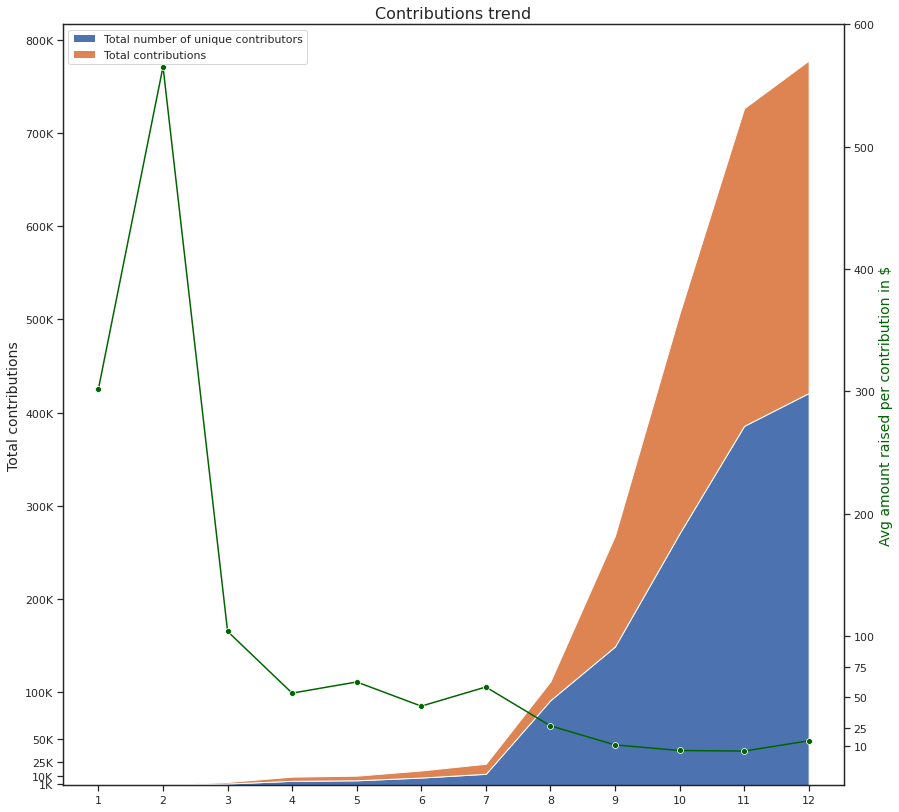

In [225]:
df_total_contributions = df_grants.groupby('round_number')['num_contributions'].sum()
df_total_unique_contributors = df_grants.groupby('round_number')['num_unique_contributors'].sum()
df_mean_raised_per_contribution = df_grants.groupby('round_number')['total'].sum() / df_total_contributions

sns.set(rc = {'figure.figsize':(14,14)})
sns.set_style('ticks')

_, ax1 = plt.subplots()
ax1.stackplot(df_total_contributions.index, df_total_contributions, df_total_unique_contributors,
              labels=['Total number of unique contributors', 'Total contributions'])
ax2 = plt.twinx()
ax2 = sns.lineplot(x=range(1, 13), y = df_mean_raised_per_contribution, marker = 'o', color = 'darkgreen', ax = ax2)

ax1.set_xticks(range(1, 13))
ax1.set_yticks([1000, 10000, 25000, 50000, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000])
ax2.set_yticks([10, 25, 50, 75, 100, 200, 300, 400, 500, 600])
ax2.set_ylabel('Avg amount raised per contribution in $', fontsize=14, color='darkgreen')
ax1.legend(loc='upper left')
plt.title('Contributions trend', fontsize=16)
plt.xlabel('Round number', fontsize=14)
ax1.set_ylabel('Total contributions', fontsize=14)
ax1.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
plt.show()